## Preliminares

In [1]:
from keras import backend as K
import numpy as np
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

BATCH = 5

2024-11-23 22:50:53.719348: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 22:50:53.727022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 22:50:53.735347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 22:50:53.737887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 22:50:53.744725: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
import logging
import warnings
warnings.filterwarnings("ignore")

# Verificar dispositivos disponibles
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Listar todas las GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

# Configurar el crecimiento de memoria para cada GPU
if gpus:
    for gpu in gpus:
        print("Activada la asignacion de memoria gradual")
        tf.config.experimental.set_memory_growth(gpu, True)

GPU encontrada: /device:GPU:0
Activada la asignacion de memoria gradual


I0000 00:00:1732398660.129380   10196 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732398662.162332   10196 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732398662.162486   10196 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732398662.227398   10196 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:
import sqlite3
import shutil
import pandas as pd

 # Comprobar si el archivo existe
if not os.path.exists('../datos/grabacion/base_datos_cod_augmented.db'):
    # Copiar el archivo
    shutil.copy('../datos/grabacion/base_datos_cod.db', '../datos/grabacion/base_datos_cod_augmented.db')
    print("Archivo copiado exitosamente..")
else:
    print("Archivo ya existe..")

# Conectar a la base de datos (crea el archivo si no existe)
conexion = sqlite3.connect("../datos/grabacion/base_datos_cod_augmented.db")

# Crear un cursor para interactuar con la base de datos
cursor = conexion.cursor()

Archivo copiado exitosamente..


In [4]:
cursor.execute("SELECT MAX(id) FROM videos_mapa")
ID = cursor.fetchone()[0]

if ID == None:
    ID = 0

ID

1886

In [5]:
CANTIDAD_VIDEOS = 5

cursor.execute("SELECT id as id_video, COUNT(*) AS cantidad FROM videos_mapa GROUP BY id HAVING COUNT(*) > "+str(CANTIDAD_VIDEOS)+"")
resultados = cursor.fetchall()

# Obtener los nombres de las columnas
columnas = [descripcion[0] for descripcion in cursor.description]

# Crear el DataFrame
df_ids = pd.DataFrame(resultados, columns=columnas)

# Utilizando .to_numpy()
ARRAY_ID = df_ids['id_video'].to_numpy()

In [6]:
# Dividir en entrenamiento y prueba (10% para prueba)
X_train_Mapa, X_test_Mapa = train_test_split(ARRAY_ID, test_size=0.1, random_state=42)
# Dividir entrenamiento en entrenamiento y validación (30% de 90% para validación)
X_train_Mapa, X_valid_Mapa = train_test_split(X_train_Mapa, test_size=0.3, random_state=42)

In [7]:
print("train ->"+str(len(X_train_Mapa)))
print("valid ->"+str(len(X_valid_Mapa)))
print("test ->"+str(len(X_test_Mapa)))

train ->4
valid ->2
test ->1


In [8]:
import ast

def crear_dataframe(lista_ids):
    # Crear un DataFrame vacío para almacenar los resultados
    df_mapa = pd.DataFrame()
    df_pov = pd.DataFrame()

    for id in lista_ids:
        query = f"SELECT * FROM videos_mapa WHERE id == {id}"
        query_pov = f"SELECT * FROM videos_pov WHERE id == {id}"

        # Leer el resultado de la consulta y añadirlo al DataFrame
        df_temporal = pd.read_sql_query(query, conexion)
        df_temporal_pov = pd.read_sql_query(query_pov, conexion)

        # Concatenar al DataFrame principal
        df_mapa = pd.concat([df_mapa, df_temporal], ignore_index=True)
        df_pov = pd.concat([df_pov, df_temporal_pov], ignore_index=True)

    return df_mapa , df_pov

def preprocesado_df(df):
    # Convertir la columna de tipo object a listas de enteros
    df['etiqueta'] = df['etiqueta'].apply(ast.literal_eval)
    # Eliminamos las filas donde 'mouse_final' sea igual a [0, 4]
    filtro = df['etiqueta'].apply(lambda x: x[1] == 4)
    df = df[~filtro]
    # Crear un filtro booleano para las filas que cumplen la condición
    condicion = df['etiqueta'].apply(lambda x: x[1] == 2)
    # Juntamos las pulsaciones y tecla en una columna
    #x_positions_2 = df['etiqueta'].apply(lambda x: str(x[0])+str(x[1]))
    x_positions_2 = df['etiqueta'].apply(lambda x: str(x[1]))
    df['etiqueta'] = x_positions_2
    # Modificar solo las filas que cumplen con la condición
    #df.loc[condicion, 'etiqueta'] = df.loc[condicion, 'etiqueta'].apply(lambda x: "12")
    return df

In [9]:
df_train_mapa , df_train_pov = crear_dataframe(X_train_Mapa)
df_valid_mapa , df_valid_pov = crear_dataframe(X_valid_Mapa)
df_test_mapa , df_test_pov = crear_dataframe(X_test_Mapa)
conexion.close()

In [10]:
df_train_mapa = preprocesado_df(df_train_mapa)
df_valid_mapa = preprocesado_df(df_valid_mapa)
df_test_mapa = preprocesado_df(df_test_mapa)

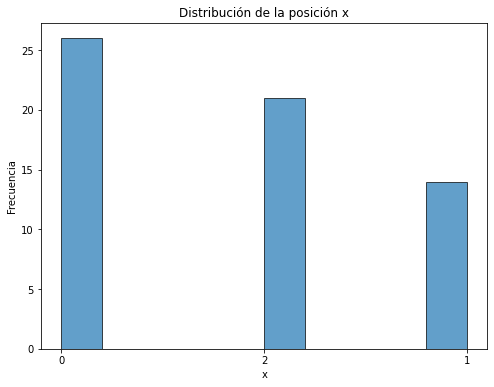

In [11]:
# Extraer la primera posición sin modificar el DataFrame
x_positions = df_train_mapa['etiqueta'].apply(lambda x: x[0])

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(x_positions, bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

In [12]:
from sklearn.utils import class_weight

def aplicar_one_hot_balanceo(df,columa):
    # Crear un DataFrame con las columnas de one-hot encoding
    one_hot_df = pd.get_dummies(df[columa], prefix='label')

    # Unir el DataFrame original con el DataFrame de one-hot encoding
    df = pd.concat([df, one_hot_df], axis=1)

    # Balanceamos los pesos para el entrenamiento
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[columa]),
        y=df[columa]
    )

    # Crear un diccionario de pesos para las clases
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    #Eliminamos la columna original
    df = df.drop(columa, axis=1)
    return df , class_weight_dict

In [13]:
df_train_mapa , pesos_train = aplicar_one_hot_balanceo(df_train_mapa,"etiqueta")
df_valid_mapa , pesos_valid = aplicar_one_hot_balanceo(df_valid_mapa,"etiqueta")
df_test_mapa , pesos_test= aplicar_one_hot_balanceo(df_test_mapa,"etiqueta")

In [14]:
ETIQUETAS = np.array(df_train_mapa.filter(like='label').columns.tolist())

In [15]:
pesos_train

{0: 0.782051282051282, 1: 1.4523809523809523, 2: 0.9682539682539683}

In [16]:
from keras.utils import Sequence
import torch

class ImageDataGenerator(Sequence):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro, **kwargs):
        self.df = df
        self.image_sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.POV = filtro
        super().__init__(**kwargs)  # Llamada al constructor de la clase base

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen
                imagen = imagen.astype("float32")

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        # Obtener y_batch después del one-hot encoding
        #y_batch = batch_df[['izquieda', 'derecha','delante']].values
        #y_batch = np.array(batch_df['mouse_final'].tolist())

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

def comprobar_contenido(X_train , Y_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    print(Y_train[num_video])
    return Y_train[num_video]


class ImageDataGeneratorVAR(ImageDataGenerator):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro,autoencoder,pesos,encoder = None,**kwargs):
        self.autoencoder = autoencoder
        self.encoder_entrenado = encoder
        self.pesos = pesos
        super().__init__(df, sequence_length, image_height, image_width, batch_size, filtro, **kwargs)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen
                imagen = imagen.astype("float32")

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        #Para autoencoder
        if self.autoencoder == True:
            return X_batch, X_batch
        else :
            # Al hacer Finetunnig te pide los pesos por el generador ¿?
            # Convertir y_batch de one-hot a índices de clase
            labels = np.argmax(y_batch, axis=1)
            sample_weights = np.array([self.pesos[label] for label in labels], dtype="float32")
            return torch.tensor(video, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64), torch.tensor(sample_weights, dtype=torch.float32)
            #return X_batch.astype("float32"), y_batch.astype("int32") , sample_weights

def comprobar_contenido(X_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')
        print(X_train[num_video][i].shape)

    plt.tight_layout()
    plt.show()

In [17]:
def concatenar_imgs_individual(X_batch):
    batch_independiente = []
    for i in range(X_batch.shape[0]):
        batch_independiente.append(X_batch[i][4])
    return np.array(batch_independiente)

In [18]:
encoder_entrenado = None
autoencoder = False
# Generador Mapa
altura_img_mini = 188
anchura_img_mini = 260
batch_size = BATCH

# Generadores para autoencoder
train_generator_Mapa = ImageDataGeneratorVAR(df_train_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True , autoencoder = autoencoder ,pesos=pesos_train, encoder= encoder_entrenado)
test_generator_Mapa = ImageDataGeneratorVAR(df_test_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder,pesos=pesos_test, encoder= encoder_entrenado)
valid_generator_Mapa = ImageDataGeneratorVAR(df_valid_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder,pesos=pesos_valid, encoder= encoder_entrenado)

6
X_batch: dtype=torch.float32, shape=torch.Size([5, 188, 260, 3])
y_batch: dtype=torch.int64, shape=torch.Size([5])
pesooooo: dtype=torch.float32, shape=torch.Size([5])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])


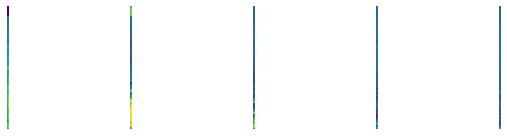

tensor(2)
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])


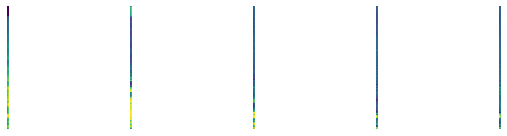

tensor(1)
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])


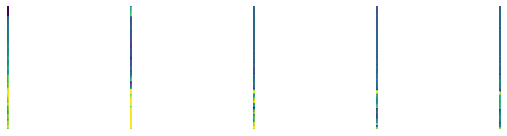

tensor(0)
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])


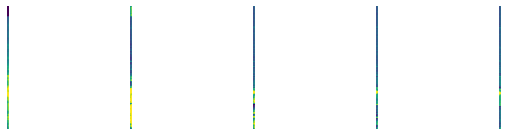

tensor(1)
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])
torch.Size([260, 3])


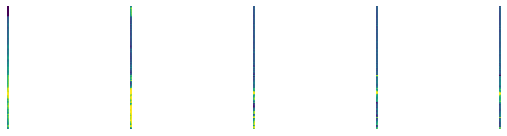

tensor(1)


In [19]:
#Cantidad de batches en los que se divide el df
print(valid_generator_Mapa.__len__())

#Comprobamos funcionamiento bach
X_batch, Y_batch ,pesooooo = valid_generator_Mapa.__getitem__(2)

print(f"X_batch: dtype={X_batch.dtype}, shape={X_batch.shape}")
print(f"y_batch: dtype={Y_batch.dtype}, shape={Y_batch.shape}")
print(f"pesooooo: dtype={pesooooo.dtype}, shape={pesooooo.shape}")

for i in range(0,batch_size):  # 4 es el maximo de conjunto de imagenes del batch creado
    # Seleccionamos ver la posicion numero 0 del batch creado
    comprobar_contenido(X_batch ,i)
    print(Y_batch[i])

In [20]:
pesos_train

{0: 1.0535344572611653, 1: 1.3637059724349159, 2: 0.7590027700831025}

## Finne-Tunned ConvNeXt


In [21]:
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ConvNeXtTiny

In [22]:
def FineTunnig_ConvNeXt(input_shape_seq, input_shape_single, num_classes):
    # Modelo base (ConvNeXt preentrenado), quitamos las capas densas con include_top=False
    base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=input_shape_single)

    # Descongelamos el modelo base
    for layer in base_model.layers:
        layer.trainable = True

    # Entrada del modelo (secuencia de imágenes)
    input_sequence = Input(shape=input_shape_seq)

    # TimeDistributed aplica el modelo base a cada paso temporal
    x = TimeDistributed(base_model)(input_sequence)
    x = TimeDistributed(GlobalAveragePooling2D())(x)  # Similar Flatten()

    # LSTM para procesar secuencias
    x = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = LSTM(128, return_sequences=False)(x)

    # Capas densas
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_sequence, outputs=output)

In [23]:
timesteps = 5
height = 188
width = 260
channels = 3

input_shape_pov = (timesteps, height, width, channels) # Modelo Pov

model = FineTunnig_ConvNeXt(input_shape_pov, (height, width, channels), len(ETIQUETAS))

I0000 00:00:1731935886.968103  575063 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731935886.968269  575063 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731935886.968371  575063 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731935886.968496  575063 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [24]:
model.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 5, 188, 260,   │          0 │   -   │
│                             │ 3)                    │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ time_distributed            │ (None, 5, 5, 8, 768)  │ 27,820,128 │   Y   │
│ (TimeDistributed)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ time_distributed_1          │ (None, 5, 768)        │          0 │   -   │
│ (TimeDistributed)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lstm (LSTM)                 │ (None, 5, 128)        │    459,264 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lstm_1 (LSTM)               │ (None, 128)           │    131,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 500)           │     64,500 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 500)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 200)           │    100,200 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 200)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 3)             │        603 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 28,576,279 (109.01 MB)

 Trainable params: 28,576,279 (109.01 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from keras.models import load_model

# Cargar el modelo
model = load_model('finetunned_ConvNext.keras')
# Listo para usar
model.summary()

I0000 00:00:1731968071.273330    5366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731968071.273486    5366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731968071.273586    5366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731968071.273709    5366 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 188, 260, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 5, 8, 768)   │    27,820,128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 768)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 128)         │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │        64,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,728,839 (327.03 MB)

 Trainable params: 28,576,279 (109.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 57,152,560 (218.02 MB)

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

# Compilar el modelo de acciones
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy',metrics=['categorical_accuracy'])

#Callbacks
early_stopping = EarlyStopping(monitor= 'val_categorical_accuracy', patience=20, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('finetunned_ConvNext.keras',monitor='val_categorical_accuracy',save_best_only=True,verbose=1)

In [ ]:
import time

# Registro del tiempo de inicio
start_time = time.time()

# Entrenamiento Mini-Mapa
history = model.fit(train_generator_Mapa,
                    epochs=1000,
                    validation_data=valid_generator_Mapa,
                    callbacks=[early_stopping,model_checkpoint]
                    )

model.save('finetunned_ConvNext.keras')

# Registro del tiempo de finalización
end_time = time.time()

Epoch 1/1000


2024-11-18 23:15:15.887919: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90400
W0000 00:00:1731968116.669725    7014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968116.706921    7014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968116.707799    7014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968116.708645    7014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968116.709497    7014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968116.710351    7014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968116.743618    7014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968116.744540    7014 gpu_

   1/4275 ━━━━━━━━━━━━━━━━━━━━ 38:00:09 32s/step - categorical_accuracy: 0.4000 - loss: 0.9695

W0000 00:00:1731968122.394481    7009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.405845    7010 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.406739    7007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.407786    7010 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.408913    7009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.409427    7007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.410153    7010 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.410938    7009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731968122.411957    7007 gp

3366/4275 ━━━━━━━━━━━━━━━━━━━━ 15:17 1s/step - categorical_accuracy: 0.3200 - loss: 1.1047

W0000 00:00:1731971519.288308    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.289239    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.289949    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.290652    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.291356    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.292062    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.292959    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.293701    7017 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971519.294434    7017 gp

3367/4275 ━━━━━━━━━━━━━━━━━━━━ 15:16 1s/step - categorical_accuracy: 0.3200 - loss: 1.1047

W0000 00:00:1731971521.266438    7016 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.267134    7007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.268149    7010 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.269047    7018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.270341    7016 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.271150    7007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.272015    7010 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.272841    7018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731971521.274237    7016 gp

4275/4275 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3217 - loss: 1.1041

W0000 00:00:1731972922.783624    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.784792    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.785671    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.786415    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.787159    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.787906    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.788647    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.789358    7008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731972922.790073    7008 gp


Epoch 1: val_categorical_accuracy improved from -inf to 0.44022, saving model to finetunned_ConvNext.keras
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 4837s 1s/step - categorical_accuracy: 0.3218 - loss: 1.1041 - val_categorical_accuracy: 0.4402 - val_loss: 1.0990
Epoch 2/1000
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3388 - loss: 1.0994
Epoch 2: val_categorical_accuracy did not improve from 0.44022
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 4768s 1s/step - categorical_accuracy: 0.3388 - loss: 1.0994 - val_categorical_accuracy: 0.4402 - val_loss: 1.0987
Epoch 3/1000
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3454 - loss: 1.0948
Epoch 3: val_categorical_accuracy did not improve from 0.44022
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 4770s 1s/step - categorical_accuracy: 0.3454 - loss: 1.0948 - val_categorical_accuracy: 0.3151 - val_loss: 1.0987
Epoch 4/1000
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3337 - loss: 1.1014
Epoch 4: val_categorical_acc

## TimeSformer

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
import torch
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, df, sequence_length, image_height, image_width, autoencoder=False, pesos=None, filtro=True, POV=False):
        self.df = df
        self.sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.autoencoder = autoencoder
        self.pesos = pesos
        self.filtro = filtro

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        frames = []

        for j in range(self.sequence_length):
            imagen = Image.open("../" + row.iloc[j + 2])  # Obtener ruta
            ancho, alto = imagen.size
            imagen = imagen.resize((224, 224))
            imagen = np.array(imagen) / 255.0  # Normalizar la imagen
            imagen = imagen.astype("float32")
            frames.append(imagen)

        video = np.stack(frames, axis=0)  # (sequence_length, H, W, C)

        if self.autoencoder:
            return torch.tensor(video, dtype=torch.float32), torch.tensor(video, dtype=torch.float32)
        else:
            y_batch = row.filter(like='label').values  # Etiquetas
            labels = np.argmax(y_batch)
            if self.pesos:
                sample_weights = self.pesos[labels]
                return torch.tensor(video, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64), torch.tensor(sample_weights, dtype=torch.float32)
            else:
                return torch.tensor(video, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)


In [23]:
from torch.utils.data import DataLoader

# Crear Dataset
dataset = ImageDataset(
    df=df_train_mapa,
    sequence_length=5,
    image_height=188,
    image_width=260,
    autoencoder=False,
    pesos=False,
    filtro=True,
)

dataset_val = ImageDataset(
    df=df_valid_mapa,
    sequence_length=5,
    image_height=188,
    image_width=260,
    autoencoder=False,
    pesos=False,
    filtro=True,
)


# Crear DataLoader
train_dataloader = DataLoader(dataset, batch_size=15, shuffle=False, num_workers=4)
val_dataloader = DataLoader(dataset_val, batch_size=15, shuffle=False, num_workers=4)

In [24]:
# Iterar sobre el DataLoader
for X_batch, y_batch in train_dataloader:
    print(len(X_batch))
    X_batch = X_batch.permute(0, 1, 4, 2, 3)  # Cambiar el orden de las dimensiones
    print("Batch de videos:", X_batch.shape)  # (batch_size, sequence_length, H, W, C)
    print("Etiquetas:", y_batch.shape)  # (batch_size,)
    break

15
Batch de videos: torch.Size([15, 5, 3, 224, 224])
Etiquetas: torch.Size([15])


In [25]:
import torch
from torch import nn, optim
from transformers import TimesformerConfig, TimesformerModel,TimesformerForVideoClassification, get_scheduler

# Configuración del modelo pequeño (tiny)
config = TimesformerConfig(
    hidden_size=100,           # Reducido
    num_attention_heads=5,    # Cabezas de atención
    num_hidden_layers=6,      # Capas para simplificar el modelo
    num_frames=5,             # Número de timesteps
    image_size=224,           # Tamaño de las imágenes
    patch_size=16,            # Tamaño del patch
    num_labels=len(ETIQUETAS)        
)

# Crear modelo basado en esta configuración
model = TimesformerForVideoClassification(config)

In [26]:
model

TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 100, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-5): 6 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=100, out_features=300, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=100, out_features=100, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense): 

In [27]:
# Convertimos el diccionario a un tensor
class_weights_tensor = torch.tensor(list(pesos_train.values())).to(device)
class_weights_tensor = class_weights_tensor.float().to(device)

In [28]:
class_weights_tensor

tensor([1.0535, 1.3637, 0.7590], device='cuda:0')

In [29]:
# Configuración de pérdida, optimizador y programador de tasas de aprendizaje
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = get_scheduler("cosine", optimizer=optimizer,
                          num_warmup_steps=5,
                          num_training_steps=len(train_dataloader) * 100)

In [30]:
# Mover el modelo a la GPU (si está disponible)
model = model.to(device)
# Early Stopping
patience = 10
best_loss = float("inf")
patience_counter = 0

# Entrenamiento
for epoch in range(100):
    model.train()
    running_loss = 0.0

    # Entrenamiento
    for batch in train_dataloader:
        inputs, labels = batch
        inputs = inputs.permute(0, 1, 4, 2, 3).to(device)  # Cambiar el orden y enviar al dispositivo
        labels = labels.to(device)

        optimizer.zero_grad()  # Limpiar gradientes antes de cada paso
        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Promedio de la pérdida para la época de entrenamiento
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            inputs = inputs.permute(0, 1, 4, 2, 3).to(device)  # Cambiar el orden y enviar al dispositivo
            labels = labels.to(device)

            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Promedio de la pérdida para la época de validación
    val_loss /= len(val_dataloader)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        # Guardar el mejor modelo
        torch.save(model.state_dict(), f"Timesformer_{accuracy:.4f}.pth")
        print("Saved model.. ")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    # Actualizar el scheduler
    scheduler.step()

Epoch 1, Training Loss: 1.1027
Epoch 1, Validation Loss: 1.1032, Validation Accuracy: 32.80%
Epoch 2, Training Loss: 1.1016
Epoch 2, Validation Loss: 1.0990, Validation Accuracy: 44.02%
Epoch 3, Training Loss: 1.1008
Epoch 3, Validation Loss: 1.0989, Validation Accuracy: 44.02%
Epoch 4, Training Loss: 1.1004
Epoch 4, Validation Loss: 1.0988, Validation Accuracy: 44.02%
Epoch 5, Training Loss: 1.1000
Epoch 5, Validation Loss: 1.0986, Validation Accuracy: 44.02%
Epoch 6, Training Loss: 1.0996
Epoch 6, Validation Loss: 1.0985, Validation Accuracy: 44.02%
Epoch 7, Training Loss: 1.0993
Epoch 7, Validation Loss: 1.0985, Validation Accuracy: 44.02%
Epoch 8, Training Loss: 1.0991
Epoch 8, Validation Loss: 1.0985, Validation Accuracy: 44.02%
Epoch 9, Training Loss: 1.0989
Epoch 9, Validation Loss: 1.0985, Validation Accuracy: 44.02%
Epoch 10, Training Loss: 1.0989
Epoch 10, Validation Loss: 1.0985, Validation Accuracy: 44.02%
Epoch 11, Training Loss: 1.0988
Epoch 11, Validation Loss: 1.0985, V

KeyboardInterrupt: 

In [ ]:
# Cargar el mejor modelo al finalizar
model.load_state_dict(torch.load("TimeSformer.pth"))
model.eval()